In [18]:
#############################
#          Imports          #
#############################

import os
import json
import spotipy
import numpy as np
import spotipy.util as util
import re
import pandas as pd
from bs4 import BeautifulSoup
from json.decoder import JSONDecodeError
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords


In [19]:
#setting up some of the needed objects for Spotify API
username = 'xxxxxx'
my_client_id = 'xxxxxx'
my_secret = 'xxxxxx'
my_redirect_uri = 'xxxxxx'
spotify = spotipy.Spotify()
scope = 'user-library-read'

#User permission
try:
    token = util.prompt_for_user_token(username, scope, my_client_id,
                                       my_secret, redirect_uri = my_redirect_uri)
except:
    os.remove(f".cache-{username}")
    token = util.prompt_for_user_token(username)
    
#getting authorization
if token:
    spotify_object = spotipy.Spotify(auth = token)
    print('Successfully authenticated')
else:
    print('Cannot get token for', username)

#saving user as an object
user = spotify_object.current_user()

#obtaining display name and follower count values for printing purposes
displayName = user['display_name']
follower_count = user['followers']['total']
artist_name =  'John Mayer'


Successfully authenticated


In [20]:
print(">>> Hello " + displayName + "!")
search_results = spotify_object.search(artist_name, 1, 0, "artist")
artist = search_results['artists']['items'][0]
print('Artist Name: ',artist['name'])
print('Genres:',artist['genres'][0])
#print('Genres:',artist['genres'][0].replace(' ', ', '))
print()
artistID = artist['id']

#albums and tracks
trackURIs = []

album_results = spotify_object.artist_albums(artistID)
album_results = album_results['items']

for album in album_results:
    albumID = album['id']
    #extracting tracks
    track_results = spotify_object.album_tracks(albumID)
    track_results = track_results['items']
    #nested iteration to add track uri to master list
    for song in track_results:
        #only appending songs where the artist is the main singer; i.e. first person listed as the artist, not feature
        if (artist_name in song['artists'][0]['name']):
            trackURIs.append(song['uri'])
    
    #if you want to include artists' collaborations and features, uncomment
    #for song in track_results:
        #for song_artist in song['artists']:
            #if song_artist['name'] == artist_name:
                #trackURIs.append(song['uri'])

>>> Hello Yoon Sung Hong!
Artist Name:  John Mayer
Genres: neo mellow



In [21]:
#With Track URIs, getting song names
#Initializing trackNames list
trackNames = []
for URI in trackURIs:
    track = spotify_object.track(URI)
    trackNames.append(track['name'])

In [22]:
#########################
# Using the Genius API  #
#########################
YOUR_CLIENT_ID = 'xxxxxx'
genius_token = 'xxxxxx'
base_url = "http://api.genius.com"
search_url = base_url + "/search"
headers = {'Authorization': 'Bearer ' + genius_token}
def get_song_info(url, list_songs, headers):
    songs = []
    for song in list_songs:
        data = {'q': song}
        response = requests.get(url, params=data, headers=headers)
        json = response.json()
        #initializing song info
        song_info = None
        for hit in json["response"]["hits"]:
            #verifying the search result and its artist is the same as the artist of our choice (i.e. Frank Ocean)
            if hit["result"]["primary_artist"]["name"] == artist_name:
                song_info = hit
                break
        if song_info:
            #verifying that the song exists in Genius. If it exists, adds on to the list.
            songs.append(song_info)
    return songs
songs = get_song_info(search_url, trackNames, headers)

In [23]:
#finding the genius urls for all songs
#initializing a dictionary
url_dict = {}
genius_url = []
for song in songs:
    url_extension = song['result']['path']
    url = 'https://genius.com' + url_extension
    genius_url.append(url)
    url_dict[song['result']['title']] = url

In [24]:
#getting lyrics
lyrics_dict = {}
for URL in genius_url:
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string
    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    lyrics_dict[URL] = lyrics

In [25]:
#storing every alphabet for later purposes
english = "a b c d e f g h i j k l m n o p q r s t u v w x y z A B C D E F G H I J K L M N O P Q R S T U V W X Y Z".split()
#initializing an array
master_array = np.array([])
#initializing a master string for later purposes
master_string = ""
#initializing a dictionary for unique words count for each song (to be used in exploratory analysis later)
song_unique_dict = {}
#iterating through each song (and its URL) and using regex expression to clean the lyrics data
for URL in genius_url:
    pretty = lyrics_dict[URL].replace("\n\n", '').replace("\n", '. ')
    pretty = re.sub(r'\[.*?\]', '', pretty)
    pretty = re.sub(r'\s+', ' ', pretty)
    pretty = pretty.replace('\'', '’')
    master_string += pretty
    word_list = pretty.lower().split()
    #filtering only english lyrics (one of the songs, Nikes, contains Japanese lyrics)
    is_english = [word[0] in english for word in word_list] 
    word_list = np.array(word_list)
    #recording the number of unique words used per song 
    song_unique_dict[URL] = len(np.unique(word_list)) #may exclude some of the stop words
    #appending the song lyrics to master array 
    master_array = np.append(master_array, word_list)
#checking if the words are stopwords
is_stopword = (np.isin(master_array, stopwords.words('english')) == False)
#subsetting only those words that are not stopwords(according to nltk pkg)
master_array = master_array[is_stopword]

In [26]:
unique, counts = np.unique(master_array, return_counts=True)
word_count = dict(zip(unique, counts))

In [27]:
#displaying the dictionary in descending order of word counts
word_count_ordered = []
for i in sorted(word_count, key=word_count.get, reverse=True):
    word_count_ordered.append(i + ": " + str(word_count[i]))
#number of different words used
len(word_count_ordered)

2680

Average # of words: 104.42241379310344 | Maximum # of words: 162


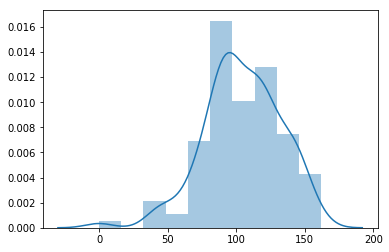

In [28]:
#average number of unique words used
unique_mean = np.mean(list(song_unique_dict.values()))
#maximum number of unique words used
unique_max = np.max(list(song_unique_dict.values()))
print("Average # of words:", unique_mean, "| "
     "Maximum # of words:", unique_max)
#distribution of unique words used in each song
sns.distplot(list(song_unique_dict.values()), bins = 10)

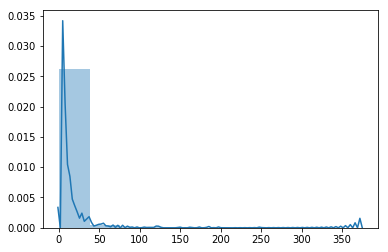

In [29]:
#distribution of the word count (number of times a word was used in all Frank Ocean's songs)
sns.distplot(list(word_count.values()), bins = 10) #excludes stop words

In [30]:
#creating a new unique words count dictionary, but with song title instead of URL as key this time
song_unique_dict_new = {'song title': list(url_dict.keys()), 'unique words count': list(song_unique_dict.values())}
#converting dictionary into data frame
song_unique_df = pd.DataFrame(data = song_unique_dict_new)
#taking out songs that were performed live - which are essentially duplicates
song_unique_df = song_unique_df[song_unique_df["song title"].str.contains("live") == False]
#ordering the data frame by unique words count, descending. displaying first 20 songs
song_unique_df.sort_values(by='unique words count', ascending=False).head(20)

,song title,unique words count
96,Split Screen Sadness,152
104,83,152
29,"Walt Grace's Submarine Test, January 1967",150
48,Stop This Train,145
93,New Deep,143
99,No Such Thing,143
101,My Stupid Mouth,141
111,No such thing - demo version,140
112,My stupid mouth - demo version,139
19,Badge and Gun,134


In [31]:
#############################
#  Named Entity Recognition #
#############################
#using stanford's NER tool
from nltk.tag.stanford import StanfordNERTagger
st = StanfordNERTagger('/Users/yoonsunghong/stanford-corenlp/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz',
               '/Users/yoonsunghong/stanford-corenlp/stanford-ner/stanford-ner.jar')

In [32]:
#using st.tag to create list with tupled categorization for entities
tag_lyrics = st.tag(master_string.split())
#filtering out the non named entities
named_e = [t for t in tag_lyrics if t[1] != 'O']
named_e

[('Paris', 'LOCATION'),
 ('Ohio', 'LOCATION'),
 ('Paris', 'LOCATION'),
 ('California', 'LOCATION'),
 ('Neil', 'PERSON'),
 ('Young', 'PERSON'),
 ('California', 'LOCATION'),
 ('Joni', 'PERSON'),
 ('California', 'LOCATION'),
 ('Olivia', 'PERSON'),
 ('Olivia.', 'LOCATION'),
 ('Something', 'LOCATION'),
 ('Tokyo.', 'ORGANIZATION'),
 ('Cause', 'ORGANIZATION'),
 ('New', 'LOCATION'),
 ('York', 'LOCATION'),
 ('New', 'LOCATION'),
 ('York', 'LOCATION'),
 ('Baton', 'LOCATION'),
 ('Rouge.', 'LOCATION'),
 ('New', 'LOCATION'),
 ('York', 'LOCATION'),
 ('Austin', 'LOCATION'),
 ('Japan', 'LOCATION'),
 ('New', 'LOCATION'),
 ('York', 'LOCATION'),
 ('euphoria.', 'LOCATION'),
 ('Orange', 'LOCATION'),
 ('Miles', 'PERSON'),
 ('Miles', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON'),
 ('Tori', 'PERSON')]

Notice how certain words are repeated in the list, suggesting that the named entity word appears multiple times in a song. Good example would be the word 'Tori', which is used exclusively in a song called 'Victoria' in the repeated choruses.

Also, notice how New and York have been categorized as two separate entities rather than one. We can fix this manually in the code later.

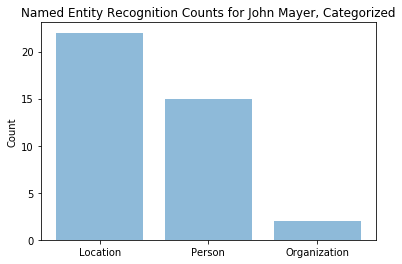

In [33]:
#counting the number of entities
list_named_count = [len([t for t in named_e if t[1] == 'LOCATION']), 
                   len([t for t in named_e if t[1] == 'PERSON']),
                   len([t for t in named_e if t[1] == 'ORGANIZATION'])]
list_named_names = ['Location', 'Person', 'Organization']
y_pos = np.arange(len(list_named_names))

plt.bar(y_pos, list_named_count, align = 'center', alpha=0.5)
plt.xticks(y_pos, list_named_names)
plt.ylabel('Count')
plt.title('Named Entity Recognition Counts for John Mayer, Categorized')
plt.show()

We can see from the barplot above that despite John Mayer having 100+ unique songs, he does not use named entities frequently in his songs. Therefore, it makes further analysis using Named Entity Recognition very difficult.